In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import datetime
from datetime import timedelta, date
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

In [46]:
def get_labels(labels_file_path):
    """
    This method gets channel labels from the labels.dat file from the house directory
    
    Input:
    labels_file_path = Path to the labels.dat file.
    
    Output:
    labels_df = Channel and appliance name dataframe.
    labels_dict = Channel and appliance name dictionary.
    """
    labels_df = pd.read_csv(labels_file_path, sep='\\s+', names=['Channel_id', 'Appliance'])
    labels_df["Channel_id"] = ["channel_"+str(i) for i in range(1,labels_df.shape[0]+1)]
    labels_dict = dict()
    for row in labels_df.iterrows():
        labels_dict[row[1]["Channel_id"]] = row[1]["Appliance"]
    return labels_df, labels_dict

In [47]:
def get_channel_list(house_path):
    """
    This method gets the list of channels from the house directory.
    
    Input:
    house_path = path to the house directory.
    
    Output:
    channel_list = list of all the channels except channel_1 (mains).
    """
    if(house_path[-1] != '/'):
        house_path = house_path + '/'
    channel_list = []
    for item in os.listdir(path):
        if 'channel_' in item and item != "channel_1.dat":
            channel_list.append(item[:-4])
    return channel_list

In [48]:
def get_channel_data(on_off_data_dir_path, channel_list):
    """
    This method loads channel on/off data from .npy files 
    generated by running 'Resampling_and_generating_appliance_on_off_data' file 
    
    Input:
    file_path = Path to the .npy files for all the channels
    equipments = List of channels for the house being analyzed
    
    Output:
    equip_dict = Dictionary of equipment and the datetime data when the equipment was turned on
    """
    channel_dict = dict()
    for channel in channel_list:
        if 'channel_' in channel and channel != "channel_1.dat":    
            # print( on_off_data_dir_path + channel)
            channel_data = np.load(on_off_data_dir_path + channel + ".npy")
            channel_data = list(channel_data)
            # Filter out only those instances where appliance is on
            channel_data = [ x for x in channel_data if x!= '0']
            # Populating dictionary with channel data using channel name as key
            channel_dict[channel] = list(channel_data) 
    return channel_dict

In [49]:
def get_min_max_dates(path_to_resampled_channel_data, channel_list):
    """
    This method finds the range of dates in which all the appliances were recorded //
    and returns a min and a max date for given appliances. 
    
    Input:
    path_to_resampled_channel_data = Path to the resampled data directory
    number_of_channels = Total number of channels in the house
    
        
    Output:
    min_date = The earliest date on which an appliance usage was recorded.
    max_date = The latest date on which an appliance usage was recorded.
    """
    min_date = datetime.datetime.max.date()
    max_date = datetime.datetime.min.date()

    for i in reversed(range(2, len(channel_list) + 1)):
        cd = np.load(path_to_resampled_channel_data + "channel_"+str(i)+".npy")
        for item in cd:
            if(item != '0'):
                datetime_obj = datetime.datetime.strptime(item, "%Y-%m-%d %H:%M:%S")
                temp_date = datetime_obj.date()
                if(temp_date < min_date):
                    min_date = temp_date
                break;

        for item in reversed(cd):
            if(item != '0'):
                datetime_obj = datetime.datetime.strptime(item, "%Y-%m-%d %H:%M:%S")
                temp_date = datetime_obj.date()
                if(temp_date > max_date):
                    max_date = temp_date
                break;
    return min_date, max_date

In [50]:
def get_dates_list(min_date, max_date):
    """
    This method finds the dates between a given set of dates.
    
    Input:
    date1 = Start date
    date2 = End date
    
    Output:
    List of date strings in between these dates
    """
    Dates = []
    start_dt = min_date
    end_dt = max_date
    for dt in daterange(start_dt, end_dt):
        Dates.append(dt.strftime("%Y-%m-%d"))
    return Dates

In [51]:
def daterange(date1, date2):
    """
    This method finds the dates between a given set of dates.
    
    Input:
    date1 = Start date
    date2 = End date
    
    Output:
    List of dates in between these dates
    """
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)

In [52]:
def get_all_times_of_day(interval):
    """
    This method generates a list of times of a day seperated by specified interval.
    
    Input:
    interval = The gap between two neighboring time slots
    
    Output:
    Time = List of times seperated by specified interval
    """
    hour = ['00','01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23']
    minute = ['00', str(interval)]
    second = '00'
    Time = []
    for hr in hour:
        for min in minute:
            temp = [hr, min, second]
            temp = ':'.join(temp)
            Time.append(temp)
    return Time

In [53]:
def get_usage_data_for_day(channel_data_dict, channel_list, date):
    """
    This method extracts the appliances that are on and their usage data for a particular day. 
    
    Input:
    channel_data_dict = Dictionary of channel and their on/off data.
    channel_list = List of channels for this house
    date = Date for which used appliances and their usage needs to be extracted
    
    Output:
    cleaned_day_data = Dictionary of appliances used that day and their usage (on timings).
    
    """
    day_data = dict()
    for channel in channel_list:
        channel_data = list(channel_data_dict[channel])
        channel_data = [ x for x in channel_data if date in x]
        day_data[channel] = channel_data
    cleaned_day_data = dict()    
    for channel in day_data.keys():
        if len(day_data[channel]) == 0:
            continue
        else:
            cleaned_day_data[channel] = day_data[channel]
    no_of_channel_w = len(cleaned_day_data.keys()) 
#     print("No of channel working on {%s} are :"%(date),end = " ")
#     print(no_of_channel_w)       
    return cleaned_day_data    

In [54]:
def get_usage_data_for_time(day_data, channel_data_dict, date, time, channel_list):
    """
    This method extracts the appliances that are on and their usage data for a particular time of the day. 
    
    Input:
    day_data = Dictionary of channel and their on/off data for the day.
    channel_data_dict = Complete dictionary of channel and their on/off data.
    date = Date for which used appliances and their usage needs to be extracted
    time = Time for which used appliances and their usage needs to be extracted
    channel_list = List of channels for this house
        
    Output:
    list = List of channels on for that time of the day.
    
    """
    temp_list = [date, time]
    temp_time = ' '.join(temp_list)
    time_data = dict()
    time_data[time] = []
    for channel in day_data.keys():
        temp_data = list(channel_data_dict[channel])
        temp_data = [ x for x in temp_data if temp_time in x]
        if len(temp_data)==0:
            continue
        else:
            time_data[channel] = temp_data
#     print("No of channels working at %s %s are :"%(date, time),end =" ")
#     print(len(time_data.keys()))       
    return list(time_data.keys())

In [55]:
def data_extractor(channel_list, channel_data_dict, dates, times):
    """
    This method extracts the appliances that are on and their usage data for a given date range. 
    
    Input:
    channel_list = List of channels for this house.
    channel_data_dict = Complete dictionary of channel and their on/off data.
    dates = Dates for which used appliances and their usage needs to be extracted.
    times = Times for which used appliances and their usage needs to be extracted.
    
        
    Output:
    list = List-of-lists of channels that are On for that period.
    
    """
    transactions = []
    no_of_ch = len(channel_list)
    # Iterate over dates in the date range
    for date in dates:
        # Get appliance usage data for day
        day_data = get_usage_data_for_day(channel_data_dict, channel_list, date)
        # Iterate over times in the 24 hour time range
        for time in times:
            # Get appliances on for time
            temp_list = get_usage_data_for_time(day_data, channel_data_dict, date, time, channel_list)           
            if len(temp_list)==0:
                continue
            else:
                transactions.append(temp_list)
    return transactions                

In [56]:
def divide_data_into_time(times, apriori_data):
    """
    This method seperates ON appliance sequences by time and Saves them in a dictionary with time slices as the key
    
    Input:
    times = List of time slices.
    apriori_data = Output of the data_extractor().
    
    Output:
    Dataframe of support and frequent itemsets.
    """
    time_sequence_dict = dict()
    for timestamp in times:
        sequence_list = []
        for data in apriori_data:
            if timestamp in data:
                sequence_list.append(data)
        time_sequence_dict[timestamp] = sequence_list
    return time_sequence_dict

In [57]:
def get_support_and_itemsets(apriori_data, minimum_support):
    """
    This method runs the apriori algorithm on the input data and returns frequent itemsets with their respective supports
    
    Input:
    apriori_data = List-of-lists of appliances On at a particular time for each day.
    minimum_support = Minimum support for getting the frequent itemsets.
    
    Output:
    Dataframe of support and frequent itemsets
    """
    te = TransactionEncoder()
    data = te.fit(apriori_data).transform(apriori_data)
    data = pd.DataFrame(data, columns = te.columns_)
    return apriori(data, min_support = minimum_support, use_colnames = True)

In [58]:
def get_channels_from_frequent_itemsets(frequent_itemsets_df):
    """
    This method returns the set of unique channels present in the support-frequent itemsets dataframe.
    This method was used to check the appliance coverage.
    
    Input:
    frequent_itemsets_df = Dataframe of support and frequent itemsets.
    
    Output:
    Set of channels present in the entire frequent itemsets
    """
    channels = set()
    for item in frequent_itemsets_df.itemsets:
        for entry in list(item):
            channels.add(entry)
    return channels

In [59]:
def get_appliances_from_channels(list_of_channels, labels_df):
    """
    This method returns a list of appliance names given a list of channels.
    
    Input:
    list_of_channels = List of channels for which names to be extracted.
    labels_df = Dataframe of channel ids and appliance names.
    
    Output:
    List of appliance names corresponding to each channel in list_of_channels
    """
    result = []
    for item in list_of_channels:
        result.append(labels_df.set_index('Channel_id').at[item, 'Appliance'])
    return result

In [60]:
def get_channels_from_rules(rule_df):
    """
    This method returns the set of unique channels present in the time-rules dataframe.
    This method was used to check the appliance coverage.
    
    Input:
    rules_df = Dataframe of time and appliances On.
    
    Output:
    Set of channels present in the rules dataframe
    """
    channel_list = []
    for sequence in rule_df['consequents']:
        list_of_channels = str(sequence)[12:-3].replace("'",'').split(", ")
        for item in list_of_channels:
            if item not in channel_list:
                channel_list.append(item)
    return channel_list

In [61]:
def get_missing_channel_list(rule_df, full_channel_set):
    """
    This method returns the set of unique channels not present in the time-rules dataframe.
    This method was used to check the appliance coverage.
    
    Input:
    rules_df = Dataframe of time and appliances On.
    full_channel_set = Set of complete channels in the house
    
    Output:
    Set of channels not present in the rules dataframe
    """
    channel_set = set()
    for sequence in rule_df['consequents']:
        list_of_channels = sequence[12:-3].replace("'",'').split(", ")
        channel_set.update(list_of_channels)
    result_1 = full_channel_set - channel_set
    return result_1

In [62]:
def change_names(recs, show_name_dict):
    res = []
    for item in recs:
        res.append(show_name_dict[item])
    return res

In [63]:
def convert_janhavis_recs_to_csv(recs_df):
    recommendation_list = []
    for item in recs_df['Recommendations']:
        recs = []
        item = item[1:-1]
        for channel in item.split(", "):
            channel = channel[2:-2]
            recs.append(channel)
        recommendations = get_appliances_from_channels(recs, labels_df)
        recommendations = change_names(recommendations, show_name_dict)
        recommendation_list.append(",".join(appliance for appliance in recommendations))
    time_recommendation_df = pd.DataFrame({"Time" : Time, "Recommendations" : recommendation_list})
    return time_recommendation_df

In [64]:
def get_ground_truth(Dates, Time, channel_data):
    datetime_channel_dict = dict()
    for date in Dates:
        for timestamp in Time:
            datetime_channel_dict[date + " " + timestamp] = set()
            for channel in channel_data.keys():
                if(date + " " + timestamp in channel_data[channel]):
                    datetime_channel_dict[date + " " + timestamp].add(channel)
    return datetime_channel_dict

In [65]:
def get_top_k_recommendations(k, Dates, recs_file_path):
    datetime_recs_dict = dict()
    recs_df = pd.read_csv(recs_file_path, header=0, names=['Time','Recommendations'])
    for date in Dates:
        for index,row in recs_df.iterrows():
            time = row['Time']
            recommendations = row['Recommendations']    
            datetime_recs_dict[date + " " + time] = set(list(recommendations.split(",")[:k]))
    return datetime_recs_dict

In [66]:
def calculate_precision(Dates, Time, ground_truth, recommendations):
    count = 0
    precision = 0
    for date in Dates:
        for timestamp in Time:
            relevant = ground_truth[date + " " + timestamp]
            recommended = recommendations[date + " " + timestamp]
            if(len(relevant) == 0):
                continue
            count += 1
            temp_precision = (len(relevant.intersection(recommended))/len(recommended))
            precision += temp_precision
    avg_precision = precision/count
    return avg_precision

In [67]:
def calculate_recall(Dates, Time, ground_truth, recommendations):
    count = 0
    recall = 0
    for date in Dates:
        for timestamp in Time:
            relevant = ground_truth[date + " " + timestamp]
            recommended = recommendations[date + " " + timestamp]
            if(len(relevant) == 0):
                continue
            count += 1
            temp_recall = (len(relevant.intersection(recommended))/len(relevant))
            recall += temp_recall
    avg_recall = recall/count
    return avg_recall

### Declare necessary variables

### House 2

In [68]:
# Disaggregated data

# path = "../Utils/Channel_On_Off_data/Disaggregated_house_2/"
# resampling_time_in_min = '30'
# min_confidence = 0.4
# min_support = 0.1
# considered_rules = 200
# labels_file = "../../Disaggregation/House_2/labels.dat"
# apriori_data_output_file = "../Utils/Channel_On_Off_data/Disaggregated_house_2/apriori_data.npy"
# rule_files_dir = "./Disaggregated_Rule_Files/"
# recommendations_file = './disaggregated_recommendations_01_04.csv'

In [71]:
# House 2 Lables

# show_name_dict = dict()
# show_name_dict['laptop'] = "Laptop"
# show_name_dict['monitor'] = "Monitor"
# show_name_dict['speakers'] = "Speakers"
# show_name_dict['server'] = "Server"
# show_name_dict['router'] = "Router"
# show_name_dict['server_hdd'] = "Server_hdd"
# show_name_dict['kettle'] = "Kettle"
# show_name_dict['rice_cooker'] = "Rice Cooker"
# show_name_dict['running_machine'] = "Running Machine"
# show_name_dict['laptop2'] = "Laptop2"
# show_name_dict['washing_machine'] = "Washing Machine"
# show_name_dict['dish_washer'] = "Dish Washer"
# show_name_dict['fridge'] = "Fridge"
# show_name_dict['microwave'] = "Microwave"
# show_name_dict['toaster'] = "Toaster"
# show_name_dict['playstation'] = "Playstation"
# show_name_dict['modem'] = "Modem"
# show_name_dict['cooker'] = "Cooker"

### House 3 

In [69]:
train = False
house = 'House_3'
min_support = 0.02
min_confidence = 0.02
considered_rules = 200
resampling_time_in_min = '30'
path = "../Utils/Channel_On_Off_data/" + house + "/"
labels_file = "../../../../Dataset/ukdale/" + house + "/labels.dat"
rule_files_dir = "./Train/Rule_Files/" + house + "/"
recommendations_file = "./Train/Recommendations/" + house + "/recommendations_" + str(min_support) + "_" + str(min_confidence) + ".csv"

In [72]:
# House 3 Lables

show_name_dict = dict()
show_name_dict['laptop'] = "Laptop"
show_name_dict['kettle'] = "Kettle"
show_name_dict['electric_heater'] = "Electric Heater"
show_name_dict['projector'] = "Projector"

In [73]:
# House 4 Lables

# show_name_dict = dict()
# show_name_dict['tv_dvd_digibox_lamp'] = "TV & DVD Digibox & Lamp"
# show_name_dict['kettle_radio'] = "Kettle & Radio"
# show_name_dict['gas_boiler'] = "Gas Boiler"
# show_name_dict['freezer'] = "Freezer"
# show_name_dict['washing_machine_microwave_breadmaker'] = "Washing Machine & Microwave & Breadmaker"

### Get labels from the labels.dat file

In [74]:
labels_df, labels_map = get_labels(labels_file)

In [75]:
labels_df

,Channel_id,Appliance
0,channel_1,aggregate
1,channel_2,kettle
2,channel_3,electric_heater
3,channel_4,laptop
4,channel_5,projector


### Get house related data

In [76]:
# Get channel list and data from channel files
channel_list = get_channel_list(path)
channel_data = get_channel_data(path, channel_list)

# Get max and min date in the channel data
min_date, max_date = get_min_max_dates(path, channel_list)

# Generate date and time list 
Dates = get_dates_list(min_date, max_date)

train_dates = Dates[:round(len(Dates)*0.9)]
test_dates = Dates[round(len(Dates)*0.9):]

Time = get_all_times_of_day(resampling_time_in_min)

In [77]:
len(test_dates)

4

### Generate rules for each time of the day 

In [97]:
# %%time

# Generate appliance ON data for each time slice of each day
apriori_dt = data_extractor(channel_list, channel_data, train_dates, Time)
print("Apriori input data generated!")

time_itemset_map = dict()
time_rules_map = dict()
time_channels_map_from_itemsets = dict()
time_channels_map_from_rules = dict()

time_appliance_map = divide_data_into_time(Time, apriori_dt)

for timestamp in list(time_appliance_map.keys()):

    print("Generating Itemsets for : " + str(timestamp))
    # Generate frequent itemsets
    time_itemset_map[timestamp] = get_support_and_itemsets(time_appliance_map[timestamp], min_support)

    # Generate rules
    time_rules_map[timestamp] = association_rules(time_itemset_map[timestamp], metric="confidence", min_threshold = min_confidence)

    # Filter rules which starts from current time slice
    rules_df = time_rules_map[timestamp]
    time_rules_map[timestamp] = rules_df[rules_df['antecedents'] == frozenset({timestamp})]

    # Get channels from frequent itemsets
    time_channels_map_from_itemsets[timestamp] = get_channels_from_frequent_itemsets(time_itemset_map[timestamp])

    # Get channels from rules
    time_channels_map_from_rules[timestamp] = get_channels_from_rules(time_rules_map[timestamp])

    # Save the rules in CSV files to a rules directory
    for timestamp, df in time_rules_map.items():
        df.to_csv(rule_files_dir + timestamp + ".csv", header=True, index=False)

# Generate Recommendations and save them to a dataframe
recommendation_list = []
for timestamp in Time:
    rule_df = time_rules_map[timestamp].sort_values(by=['confidence'], ascending=False)
    recommended_channels = get_channels_from_rules(rule_df[:considered_rules])
    channel_names = ",".join(appliance for appliance in recommended_channels)
    if(channel_names == ''):
        channel_names = 'None'
    recommendation_list.append(channel_names)
time_recommendation_df = pd.DataFrame({"Time" : Time, "Recommendations" : recommendation_list})
print("Finished generating recommendations. Saving to file...")

time_recommendation_df.to_csv(recommendations_file)
print("Recommendations saved to file!")

Apriori input data generated!
Generating Itemsets for : 00:00:00
Generating Itemsets for : 00:30:00
Generating Itemsets for : 01:00:00
Generating Itemsets for : 01:30:00
Generating Itemsets for : 02:00:00
Generating Itemsets for : 02:30:00
Generating Itemsets for : 03:00:00
Generating Itemsets for : 03:30:00
Generating Itemsets for : 04:00:00
Generating Itemsets for : 04:30:00
Generating Itemsets for : 05:00:00
Generating Itemsets for : 05:30:00
Generating Itemsets for : 06:00:00
Generating Itemsets for : 06:30:00
Generating Itemsets for : 07:00:00
Generating Itemsets for : 07:30:00
Generating Itemsets for : 08:00:00
Generating Itemsets for : 08:30:00
Generating Itemsets for : 09:00:00
Generating Itemsets for : 09:30:00
Generating Itemsets for : 10:00:00
Generating Itemsets for : 10:30:00
Generating Itemsets for : 11:00:00
Generating Itemsets for : 11:30:00
Generating Itemsets for : 12:00:00
Generating Itemsets for : 12:30:00
Generating Itemsets for : 13:00:00
Generating Itemsets for :

In [111]:
# time_recommendation_df

In [99]:
datetime_channel_dict = get_ground_truth(test_dates, Time, channel_data)

In [100]:
# datetime_channel_dict

In [101]:
recs_df = pd.read_csv(recommendations_file, header=0, names=['Time','Recommendations'])

In [102]:
# recs_df.head()

In [112]:
# recs_df

In [104]:
datetime_recs_dict = dict()
for date in Dates:
    for index,row in recs_df.iterrows():
        time = row['Time']
        recommendations = row['Recommendations']
        datetime_recs_dict[date + " " + time] = set(list(recommendations.split(",")[:10]))

In [105]:
# datetime_recs_dict

In [106]:
average_precision = calculate_precision(test_dates, Time, datetime_channel_dict, datetime_recs_dict)
print(average_precision)

0.3969298245614035


In [108]:
average_recall = calculate_recall(test_dates, Time, datetime_channel_dict, datetime_recs_dict)
print(average_recall)

0.7368421052631579


In [110]:
average_f1_score = (2 * average_precision * average_recall)/(average_precision + average_recall)
print(average_f1_score)

0.5159319963351318


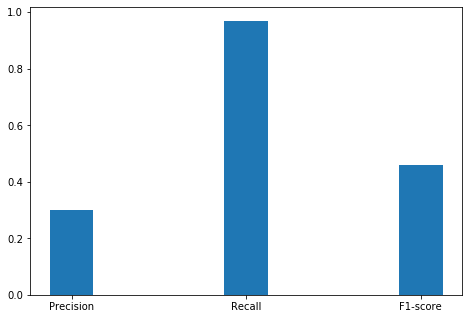

In [113]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = ['Precision', 'Recall', 'F1-score']
students = [0.30, 0.97, 0.46]
ax.bar(langs,students, width = 0.25)
plt.show()